### 0. PRIPREMA

In [67]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jun  7 18:36:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060        Off | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P8              N/A / 115W |   2187MiB /  8188MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [68]:
!pip install scikit-learn opencv-python pillow tensorflow==2.8.0 matplotlib

In [69]:
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pathlib
import cv2
import random
from tensorflow.keras import models, layers, optimizers
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import numpy as np
warnings.filterwarnings('ignore')

In [70]:
# PROVJERA AKO GPU MOŽE OBRAĐIVATI TENSORFLOW
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Jednostavan primjer množenja matrica
with tf.device('/GPU:0'):
    a = tf.constant([[2.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[2.0, 1.0], [0.0, 1.0]])
    c = tf.matmul(a, b)
    print("Result of matrix multiplication:\n", c)

TensorFlow version: 2.8.0
Num GPUs Available:  1
Result of matrix multiplication:
 tf.Tensor(
[[4. 4.]
 [6. 7.]], shape=(2, 2), dtype=float32)


In [71]:
### RAZNE METODE KORIŠTENE U NOTEBOOKU
def plot_model_accuracy(history):
  loss_train = history.history['accuracy']
  loss_val = history.history['val_accuracy']
  epochs = range(1, len(loss_train)+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  plt.legend()
  plt.show()

def plot_model_loss(history):
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  epochs = range(1, len(loss_train)+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.ylim(0,10)
  plt.legend()
  plt.show()

# CONFUSION MATRIX

def generate_report_and_matrix(model_path, X_val, y_val):
    best_model = models.load_model(model_path)
    loss, accuracy = best_model.evaluate(X_val, y_val)
    # Make predictions
    y_pred = best_model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_pred_classes)

    # Classification Report
    class_report = classification_report(y_val, y_pred_classes, target_names=[str(i) for i in range(10)])

    print("Classification Report:\n")
    print(class_report)
    
    return conf_matrix

def plot_confusion_matrix(conf_matrix):
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [72]:
# PREGLED SLIKA
def plot_image(X,y ,index):
    plt.figure(figsize = (10,10))
    plt.imshow(X[index])
    plt.xlabel(y[index])

def list_and_open_image(data_dir_path, club_name, image_index):
    data_dir = pathlib.Path(data_dir_path)
    club_images = list(data_dir.glob(f'{club_name}/*'))
    print(club_images[:5])
    image = Image.open(str(club_images[image_index]))
    image.show()

# PLOT SLIKE - RANDOM
def plot_images(combined_dict):
    fig, ax = plt.subplots(2, 5, figsize=(10, 5))
    for i, (club_name, club_info) in enumerate(combined_dict.items()):
        random_index = random.randint(0, 139) # odaberi random sliku
        img = cv2.imread(str(club_info['images'][random_index]))
        resized_img = cv2.resize(img, (64, 64))
        ax[i//5, i%5].imshow(resized_img)
        ax[i//5, i%5].set_title(club_name, fontdict={'fontsize': 12, 'font': 'monospace'})
        ax[i//5, i%5].axis('off')
    plt.show()

# PROVJERA VELIČINE SLIKE - RANDOM
def image_size_check(combined_dict):
    random_label = random.choice(list(combined_dict.keys()))
    random_index = random.randint(0, len(combined_dict[random_label]['images']) - 1)
    img = cv2.imread(str(combined_dict[random_label]['images'][random_index]))
    return img.shape

In [73]:
# LISTANJE DATOTEKA
data_dir = 'dataset_32/training'
data_dir = pathlib.Path(data_dir)

In [74]:
# DICT SA KLUBOVIMA I LABELAMA
klubovi_dict = {
    'dinamo': {'images': list(data_dir.glob('dinamo/*')), 'label': 0},
    'gorica': {'images': list(data_dir.glob('gorica/*')), 'label': 1},
    'hajduk': {'images': list(data_dir.glob('hajduk/*')), 'label': 2},
    'istra': {'images': list(data_dir.glob('istra/*')), 'label': 3},
    'lokomotiva': {'images': list(data_dir.glob('lokomotiva/*')), 'label': 4},
    'osijek': {'images': list(data_dir.glob('osijek/*')), 'label': 5},
    'rijeka': {'images': list(data_dir.glob('rijeka/*')), 'label': 6},
    'rudes': {'images': list(data_dir.glob('rudes/*')), 'label': 7},
    'slaven': {'images': list(data_dir.glob('slaven/*')), 'label': 8},
    'varazdin': {'images': list(data_dir.glob('varazdin/*')), 'label': 9},
}

In [75]:
br_slicica = len(list(data_dir.glob('*/*.jpg')))

# LISTAJ BROJ SLICICA PO KLUBOVIMA
klubovi = [str(klub).split('/')[-1] for klub in klubovi_dict.keys()]

print(f'{klubovi},\n Ukupni broj slicica: {br_slicica}')

['dinamo', 'gorica', 'hajduk', 'istra', 'lokomotiva', 'osijek', 'rijeka', 'rudes', 'slaven', 'varazdin'],
 Ukupni broj slicica: 14000


In [76]:
# IZLISTAJ BROJ SLICICA PO KLUBU
for ime, info in klubovi_dict.items():
    print(f"{ime}: {len(info['images'])} slicica")

dinamo: 1400 slicica
gorica: 1400 slicica
hajduk: 1400 slicica
istra: 1400 slicica
lokomotiva: 1400 slicica
osijek: 1400 slicica
rijeka: 1400 slicica
rudes: 1400 slicica
slaven: 1400 slicica
varazdin: 1400 slicica


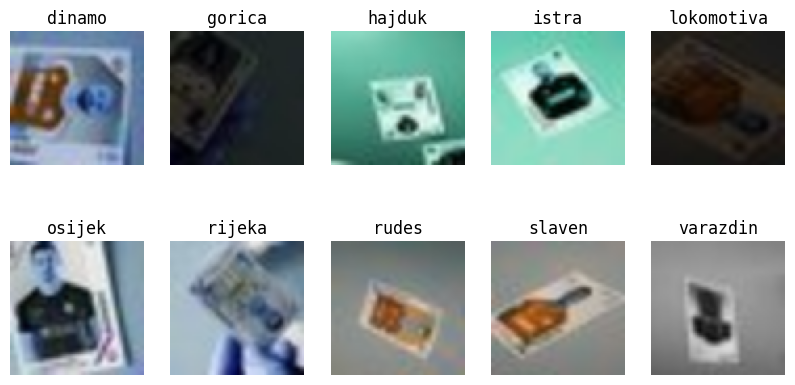

In [77]:
# PREGLED SLIKA IZ DATASETA
plot_images(klubovi_dict)

In [78]:
# PROVJERA VELIČINE SLIKE
image_size_check(klubovi_dict)

(32, 32, 3)

In [79]:
# BROJ KLASA
num_classes = 10
# RESIZE SVIH SLIKA NA 128X128 PX
#X - slike, y - labeli

X, y = [], []

for klub_name, klub_info in klubovi_dict.items():
    for image in klub_info['images']:
        img = cv2.imread(str(image))
        if img is not None:
            X.append(img)
            y.append(klubovi_dict[klub_name]['label'])
        else:
            print(f"Image at {image} could not be read.")

In [80]:
# PROVJERI VELIČINU SLIKA NAKON KONVERZIJE
print(f"X shape: {X[0].shape}\ny shape: {len(y)}")

X shape: (32, 32, 3)
y shape: 14000


In [81]:
# PREACI U NUMPY ARRAY
X = np.array(X)
y = np.array(y)

In [82]:
#TRAIN TEST SPLIT  (train 75% test 25%)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [83]:
# NORMALIZACIJA SLIKA
X_train = X_train / 255
X_val = X_val / 255

### 1. model

In [84]:
from tensorflow.python.keras import models, layers

model = models.Sequential(name="AlphaModel")
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "AlphaModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 4,210,090
Trainable params: 4,210,090
Non-trainable params: 0
______________________________________________

In [85]:
from tensorflow import keras

loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='sgd', loss=loss_fn, metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

epochs = 20
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[callback])

Epoch 1/20
263/263 [==============================] - 1s 4ms/step - loss: 2.2858 - accuracy: 0.1430 - val_loss: 2.2546 - val_accuracy: 0.1652
Epoch 2/20
263/263 [==============================] - 1s 3ms/step - loss: 2.2216 - accuracy: 0.1862 - val_loss: 2.2102 - val_accuracy: 0.1948
Epoch 3/20
263/263 [==============================] - 1s 4ms/step - loss: 2.1516 - accuracy: 0.2354 - val_loss: 2.1739 - val_accuracy: 0.2014
Epoch 4/20
263/263 [==============================] - 1s 3ms/step - loss: 2.0855 - accuracy: 0.2696 - val_loss: 2.0970 - val_accuracy: 0.2290
Epoch 5/20
263/263 [==============================] - 1s 3ms/step - loss: 2.0258 - accuracy: 0.2893 - val_loss: 2.0170 - val_accuracy: 0.3314
Epoch 6/20
263/263 [==============================] - 1s 3ms/step - loss: 1.9706 - accuracy: 0.3073 - val_loss: 2.0142 - val_accuracy: 0.2967
Epoch 7/20
263/263 [==============================] - 1s 3ms/step - loss: 1.9169 - accuracy: 0.3320 - val_loss: 1.9414 - val_accuracy: 0.3290
Epoch 

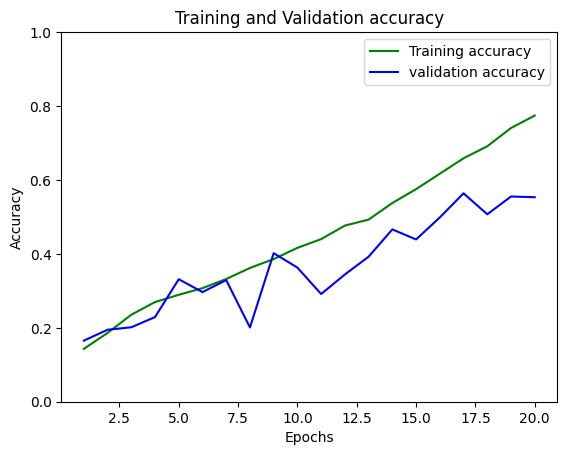

In [86]:
plot_model_accuracy(history)

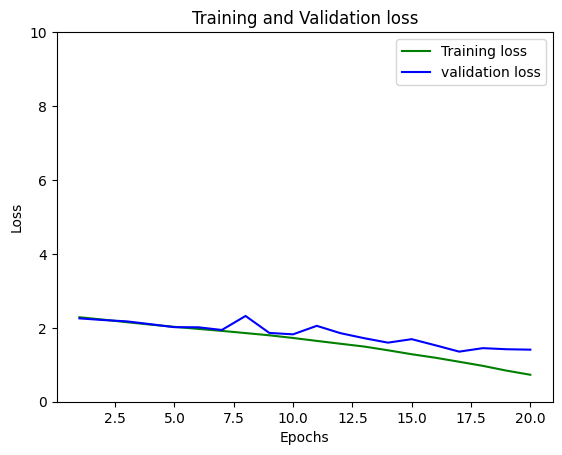

In [87]:
plot_model_loss(history)

### DRUGI MODEL BETA

In [88]:
# DODANI BATCH NORMAIZATION, JOŠ JEDAN SLOJ I DROPOUT
from tensorflow.python.keras import models, layers
from tensorflow.keras.layers import BatchNormalization

model = models.Sequential(name="BetaModel")
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(layers.Activation(activation='relu'))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Dropout(0.25))


model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "BetaModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18

In [89]:
# adam optimizer
from tensorflow import keras

loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

epochs = 20
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[callback])

Epoch 1/20
263/263 [==============================] - 2s 7ms/step - loss: 2.0661 - accuracy: 0.2465 - val_loss: 2.1615 - val_accuracy: 0.2886
Epoch 2/20
263/263 [==============================] - 1s 4ms/step - loss: 1.5314 - accuracy: 0.4768 - val_loss: 1.7471 - val_accuracy: 0.4048
Epoch 3/20
263/263 [==============================] - 1s 5ms/step - loss: 1.1381 - accuracy: 0.6156 - val_loss: 1.4127 - val_accuracy: 0.5348
Epoch 4/20
263/263 [==============================] - 1s 5ms/step - loss: 0.7761 - accuracy: 0.7411 - val_loss: 0.8764 - val_accuracy: 0.7110
Epoch 5/20
263/263 [==============================] - 1s 5ms/step - loss: 0.4898 - accuracy: 0.8362 - val_loss: 0.8168 - val_accuracy: 0.7467
Epoch 6/20
263/263 [==============================] - 1s 5ms/step - loss: 0.3281 - accuracy: 0.8940 - val_loss: 0.8291 - val_accuracy: 0.7438
Epoch 7/20
263/263 [==============================] - 2s 6ms/step - loss: 0.1990 - accuracy: 0.9343 - val_loss: 0.8104 - val_accuracy: 0.7819
Epoch 

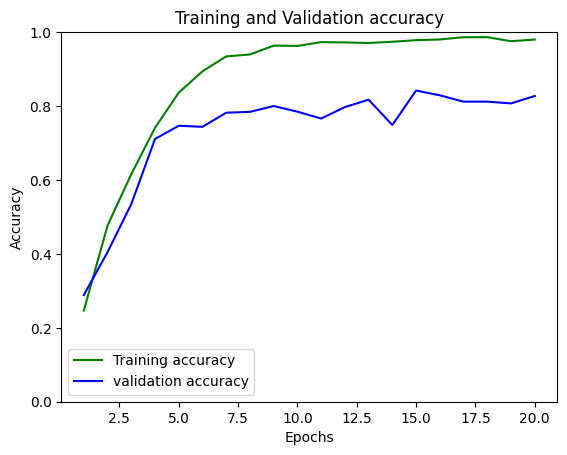

In [90]:
plot_model_accuracy(history)

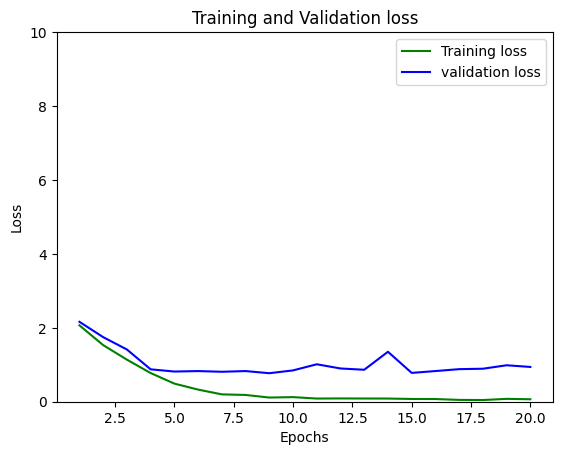

In [91]:
plot_model_loss(history)

### treći model gama

In [92]:
# DODANI BATCH NORMAIZATION, JOŠ JEDAN SLOJ I DROPOUT
# dropoput na 0.25 i na 0.5 na zadnjem sloju
# image augmentation
# kernel regularization 0.001, za smanjivanje overfittinga
# dodatni sloj
from tensorflow.keras import models, layers, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)
datagen.fit(X_train)

# Model Architecture
model = models.Sequential(name="GamaModel")
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "GamaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18

In [93]:
# adam optimizer
# broj epoha na 250
# batch size 32
# dodan learning rate
# callback za early stopping - maknut
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# Callbacks
#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Train Model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler])

Epoch 1/50
329/329 [==============================] - 3s 7ms/step - loss: 3.3192 - accuracy: 0.1544 - val_loss: 3.3250 - val_accuracy: 0.1171 - lr: 0.0010
Epoch 2/50
329/329 [==============================] - 2s 7ms/step - loss: 2.7889 - accuracy: 0.2035 - val_loss: 3.3321 - val_accuracy: 0.1569 - lr: 0.0010
Epoch 3/50
329/329 [==============================] - 2s 6ms/step - loss: 2.5407 - accuracy: 0.2386 - val_loss: 2.3214 - val_accuracy: 0.2883 - lr: 0.0010
Epoch 4/50
329/329 [==============================] - 2s 6ms/step - loss: 2.3213 - accuracy: 0.2920 - val_loss: 2.3271 - val_accuracy: 0.2794 - lr: 0.0010
Epoch 5/50
193/329 [================>.............] - ETA: 0s - loss: 2.2091 - accuracy: 0.3227

KeyboardInterrupt: 

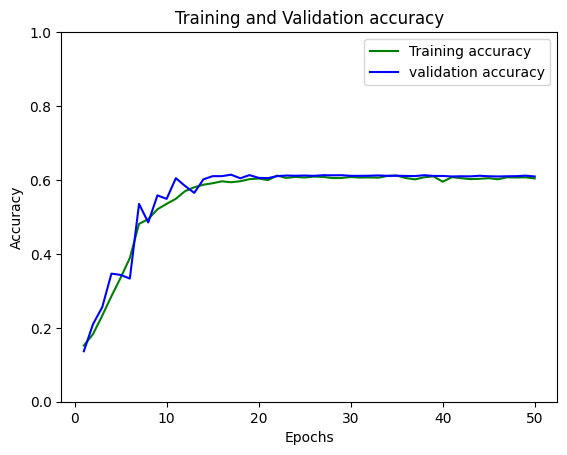

In [ ]:
plot_model_accuracy(history)

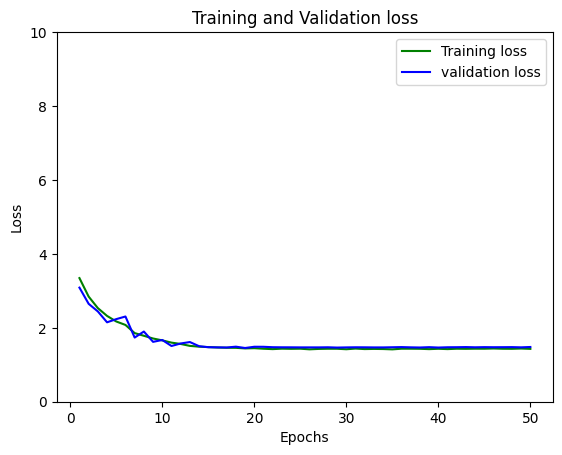

In [ ]:
plot_model_loss(history)

### 4. model delta

In [ ]:
# data augm
from tensorflow.keras import models, layers, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Increase data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    zoom_range=0.2
)
datagen.fit(X_train)

In [ ]:
# DODANI BATCH NORMAIZATION, JOŠ JEDAN SLOJ I DROPOUT
# dropoput na 0.28
# dodatni sloj
# data augmentation
# povećana kompleksnost modela
model = models.Sequential(name="DeltaModel")
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "DeltaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        1

In [ ]:
# adam optimizer
# broj epoha na 20
# batch size 64
# ugašen callback
# Compile Model with an adjusted learning rate
from tensorflow import keras
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Callbacks
#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
#checkpoint = callbacks.ModelCheckpoint('SHNL_model32.h5', monitor='val_loss', save_best_only=True)

# Train Model
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler])

Epoch 1/100
165/165 [==============================] - 3s 13ms/step - loss: 3.4745 - accuracy: 0.1394 - val_loss: 3.2505 - val_accuracy: 0.1077 - lr: 0.0010
Epoch 2/100
165/165 [==============================] - 2s 12ms/step - loss: 2.9654 - accuracy: 0.1920 - val_loss: 3.0737 - val_accuracy: 0.1246 - lr: 0.0010
Epoch 3/100
165/165 [==============================] - 2s 12ms/step - loss: 2.6797 - accuracy: 0.2353 - val_loss: 2.7357 - val_accuracy: 0.1931 - lr: 0.0010
Epoch 4/100
165/165 [==============================] - 2s 13ms/step - loss: 2.4521 - accuracy: 0.2771 - val_loss: 2.5206 - val_accuracy: 0.2429 - lr: 0.0010
Epoch 5/100
165/165 [==============================] - 2s 13ms/step - loss: 2.2897 - accuracy: 0.3180 - val_loss: 2.1872 - val_accuracy: 0.3477 - lr: 0.0010
Epoch 6/100
165/165 [==============================] - 2s 12ms/step - loss: 2.1693 - accuracy: 0.3622 - val_loss: 2.1401 - val_accuracy: 0.3949 - lr: 0.0010
Epoch 7/100
165/165 [==============================] - 2s 

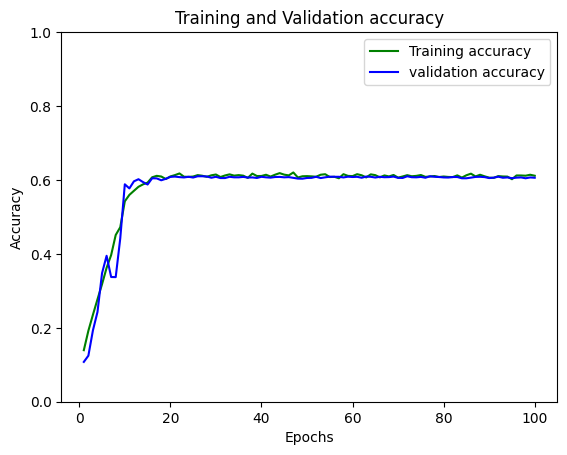

In [ ]:
plot_model_accuracy(history)

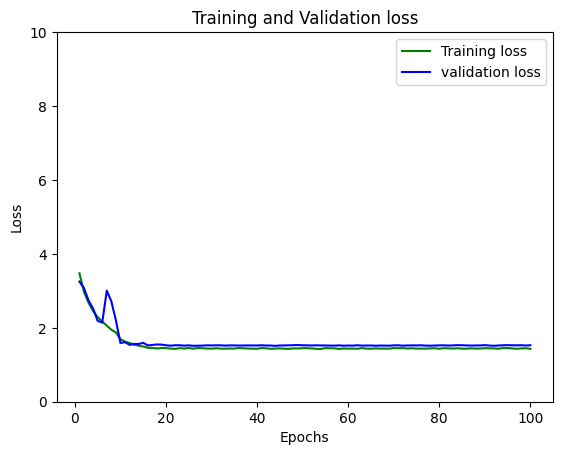

In [ ]:
plot_model_loss(history)

### MODEL 5. EPSILON

In [94]:
# MODEL 5

from tensorflow.keras import models, layers, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
)
datagen.fit(X_train)

# Model Architecture
model = models.Sequential(name="DeltaModel")
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), padding='same',  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# dodano na 85%
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (3, 3), padding='same', activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (3, 3), padding='same', activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.25))
# ## dodano na 93% <- čošiji rezultat
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.25))




model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "DeltaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 64)        1

In [95]:
# Compile Model
from tensorflow import keras
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
checkpoint = callbacks.ModelCheckpoint('SHNL_model32.h5', monitor='val_loss', save_best_only=True)

# Train Model
history = model.fit(X_train, y_train, batch_size=32,
                     epochs=150,
                     validation_data=(X_val, y_val),
                     callbacks=[lr_scheduler, checkpoint, early_stopping])

# dignuto sa 150 na 200 epoha, batch size 64

############ data gen
# Create data generators
#train_generator = datagen.flow(X_train, y_train, batch_size=32)
#val_datagen = ImageDataGenerator()  # No augmentation for validation data
#val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Train Model
#history = model.fit(
#    train_generator,
#    steps_per_epoch=len(X_train) // 32,
#    epochs=150,
#    validation_data=val_generator,
#    validation_steps=len(X_val) // 32,
#    callbacks=[early_stopping, lr_scheduler, checkpoint]
#)

Epoch 1/150
329/329 [==============================] - 4s 11ms/step - loss: 3.3931 - accuracy: 0.1847 - val_loss: 3.2294 - val_accuracy: 0.1160 - lr: 0.0010
Epoch 2/150
329/329 [==============================] - 4s 11ms/step - loss: 2.5234 - accuracy: 0.2573 - val_loss: 2.7275 - val_accuracy: 0.2377 - lr: 0.0010
Epoch 3/150
329/329 [==============================] - 3s 9ms/step - loss: 2.3811 - accuracy: 0.2683 - val_loss: 2.2797 - val_accuracy: 0.2791 - lr: 0.0010
Epoch 4/150
329/329 [==============================] - 4s 11ms/step - loss: 2.1900 - accuracy: 0.2944 - val_loss: 2.1234 - val_accuracy: 0.2897 - lr: 0.0010
Epoch 5/150
329/329 [==============================] - 3s 9ms/step - loss: 2.1707 - accuracy: 0.2999 - val_loss: 2.1412 - val_accuracy: 0.2974 - lr: 0.0010
Epoch 6/150
329/329 [==============================] - 3s 11ms/step - loss: 2.0845 - accuracy: 0.3127 - val_loss: 2.3972 - val_accuracy: 0.2291 - lr: 0.0010
Epoch 7/150
329/329 [==============================] - 3s 10

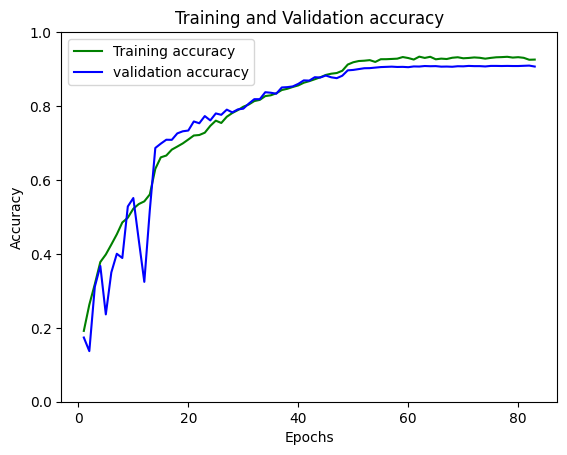

In [ ]:
plot_model_accuracy(history)

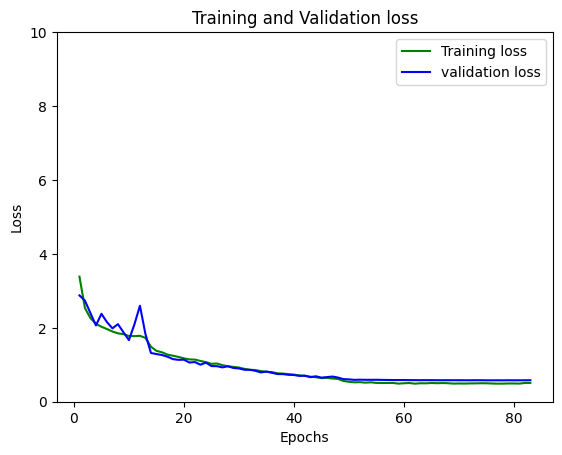

In [ ]:
plot_model_loss(history)

110/110 [==============================] - 0s 3ms/step - loss: 0.5786 - accuracy: 0.9086
Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       352
           1       0.94      0.96      0.95       343
           2       0.91      0.92      0.91       377
           3       0.96      0.94      0.95       334
           4       0.84      0.82      0.83       365
           5       0.94      0.95      0.94       332
           6       0.93      0.87      0.90       372
           7       0.92      0.92      0.92       347
           8       0.84      0.83      0.83       336
           9       0.89      0.92      0.90       342

    accuracy                           0.91      3500
   macro avg       0.91      0.91      0.91      3500
weighted avg       0.91      0.91      0.91      3500



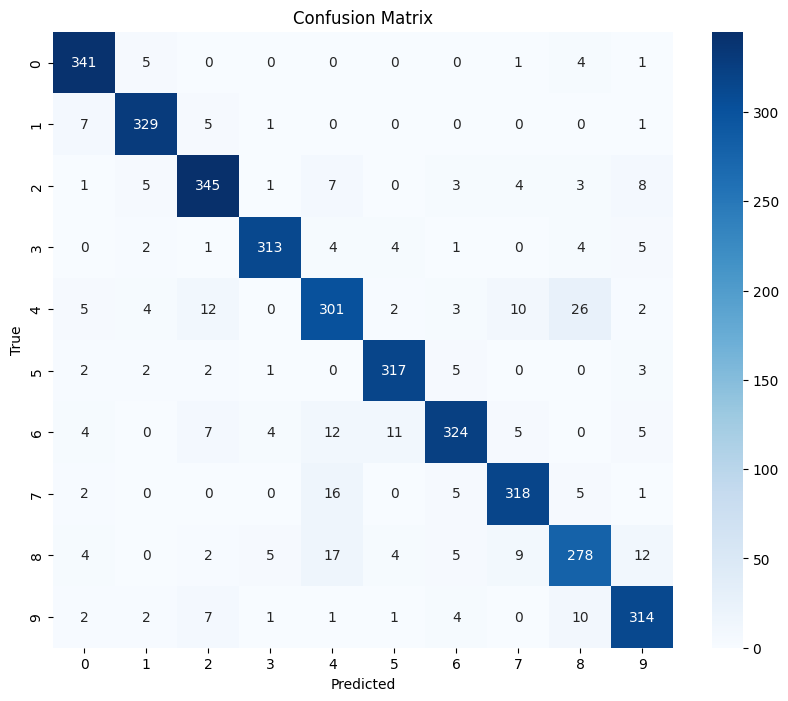

In [ ]:
conf_matrix = generate_report_and_matrix('SHNL_model32.h5', X_val, y_val)
plot_confusion_matrix(conf_matrix)

In [38]:
# time to test the model

# Load the best model
best_model = models.load_model('SHNL_model32.h5')
# Load the test data
data_dir = 'test_32'
data_dir = pathlib.Path(data_dir)

# use the same dictionary as for training data klubovi_dict
# DICT SA KLUBOVIMA I LABELAMA

test_klubovi_dict = {
    'dinamo': {'images': list(data_dir.glob('dinamo/*')), 'label': 0},
    'gorica': {'images': list(data_dir.glob('gorica/*')), 'label': 1},
    'hajduk': {'images': list(data_dir.glob('hajduk/*')), 'label': 2},
    'istra': {'images': list(data_dir.glob('istra/*')), 'label': 3},
    'lokomotiva': {'images': list(data_dir.glob('lokomotiva/*')), 'label': 4},
    'osijek': {'images': list(data_dir.glob('osijek/*')), 'label': 5},
    'rijeka': {'images': list(data_dir.glob('rijeka/*')), 'label': 6},
    'rudes': {'images': list(data_dir.glob('rudes/*')), 'label': 7},
    'slaven': {'images': list(data_dir.glob('slaven/*')), 'label': 8},
    'varazdin': {'images': list(data_dir.glob('varazdin/*')), 'label': 9},
}


In [39]:
br_slicica = len(list(data_dir.glob('*/*.jpg')))

# LISTAJ BROJ SLICICA PO KLUBOVIMA
klubovi = [str(klub).split('/')[-1] for klub in test_klubovi_dict.keys()]

print(f'{klubovi},\n Ukupni broj slicica: {br_slicica}')

['dinamo', 'gorica', 'hajduk', 'istra', 'lokomotiva', 'osijek', 'rijeka', 'rudes', 'slaven', 'varazdin'],
 Ukupni broj slicica: 1400


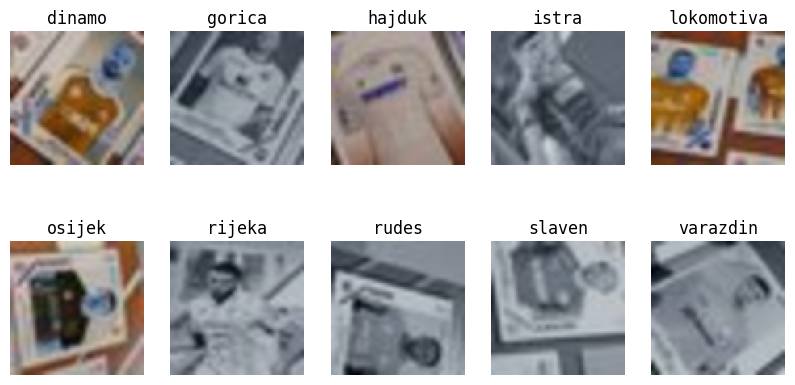

In [59]:
plot_images(test_klubovi_dict)

In [60]:
# Load the test data
X_test, y_test = [], []

for klub_name, klub_info in test_klubovi_dict.items():
    for image in klub_info['images']:
        img = cv2.imread(str(image))
        if img is not None:
            X_test.append(img)
            y_test.append(test_klubovi_dict[klub_name]['label'])
        else:
            print(f"Image at {image} could not be read.")

# Convert to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)


# Normalize the test data

X_test = X_test / 255

Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.24      0.27       140
           1       0.64      0.45      0.53       140
           2       0.12      0.07      0.09       140
           3       0.83      0.25      0.38       140
           4       0.20      0.45      0.28       140
           5       0.40      0.40      0.40       140
           6       0.25      0.42      0.31       140
           7       0.28      0.26      0.27       140
           8       0.32      0.24      0.28       140
           9       0.45      0.45      0.45       140

    accuracy                           0.32      1400
   macro avg       0.38      0.32      0.33      1400
weighted avg       0.38      0.32      0.33      1400



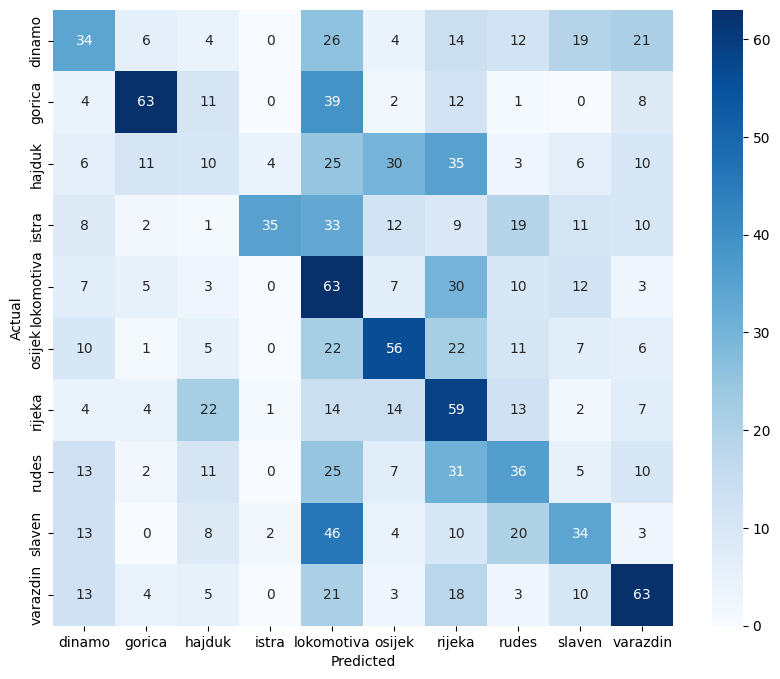

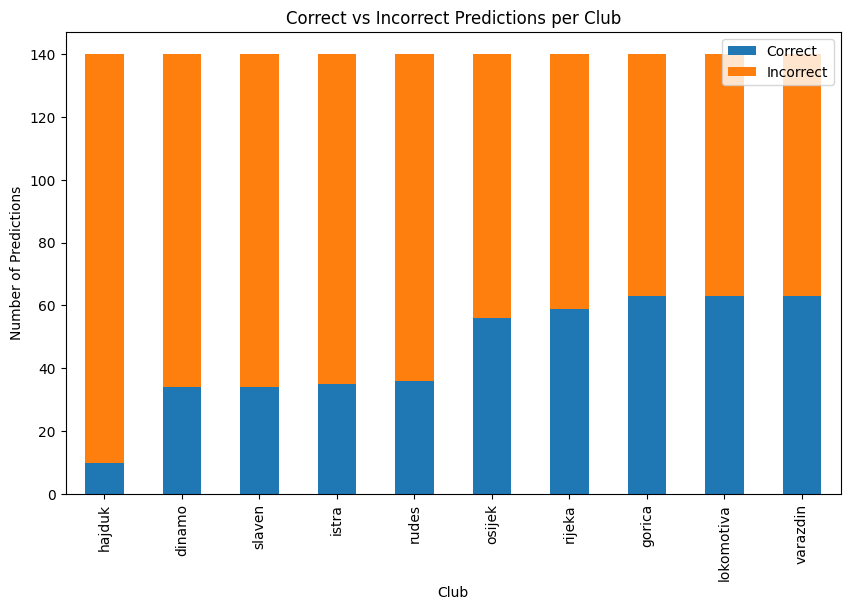

In [65]:
# Make predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, target_names=[str(i) for i in range(10)])

print("Classification Report:\n")
print(class_report)

# Plot Confusion Matrix

club_names = list(test_klubovi_dict.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=club_names, yticklabels=club_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# can you create a bar chart grouping the number of correct and incorrect predictions per club?

correct = (y_test == y_pred_classes)
correct = correct.astype(int)

correct_dict = {club: [0, 0] for club in club_names}

for i in range(len(y_test)):
    if correct[i] == 1:
        correct_dict[club_names[y_test[i]]][0] += 1
    else:
        correct_dict[club_names[y_test[i]]][1] += 1

correct_dict

# create a bar chart with correct dict

import pandas as pd

correct_df = pd.DataFrame(correct_dict).T
correct_df.columns = ['Correct', 'Incorrect']
correct_df = correct_df.sort_values(by='Correct')

correct_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Correct vs Incorrect Predictions per Club')
plt.xlabel('Club')
plt.ylabel('Number of Predictions')
plt.show()

Text(0.5, 1.0, 'Predicted class: 1')

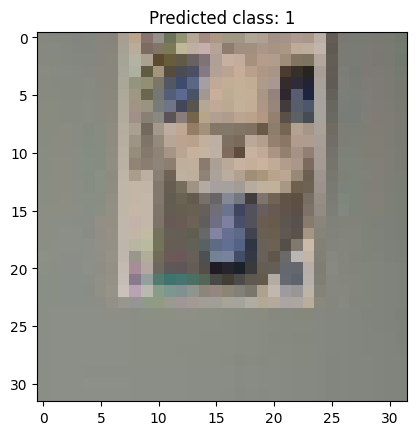

In [66]:
# How to validate a single image that is not part of the dataset?
# Load the model

# Load the image


# Resize the image
# Normalize the image
# Predict the class
# Display the image and the predicted class

# write the code for the steps above

# Load the model
model = models.load_model('SHNL_model32.h5')

# Load the image
image_path = 'test_32/gorica_0002.jpg'
image = cv2.imread(image_path)

# Resize the image
image = cv2.resize(image, (32, 32))

# Normalize the image
image = image / 255

# Predict the class
prediction = model.predict(np.array([image]))

# Display the image and the predicted class
plt.imshow(image)
plt.title(f"Predicted class: {np.argmax(prediction)}")
